Задание 1:

В папке с данными (data) расположен датасет bbc , который содержит 5 классов новостных статей (business, entertainment, politics, sport, tech). Вам необходимо реализовать следующее:

1. Обучить любой (на ваш выбор) алгоритм классификации из классических алгоритмов машинного обучения (не нейронная сеть!) и измерить метрику качества работы модели (не забываем также проверять качество на инференсе).
2. Дообучить модель DistillBert для многоклассовой классификации и проверить также качество работы алгоритма (н забываем проверять качество на инференсе). Похожий код был продемонстрирован на лекции, думаем головой, не копипастите, есть нюансы в данной задаче.
3. Оформить оба решения в пайплайны. Отдаем новости – получаем метку класса и вероятность. Соскрапить или собрать вручную по пять свежих новостей с ресурса (https://www.bbc.com/news - ссылки на новости прикрепить в ноутбуке) для каждого из классов и прогнать на них пайплайны.  Получить результаты инференса пайплайнов, и оценить какое из решений лучше.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import textwrap
import os
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import warnings
import re

# Загрузка необходимых пакетов NLTK
nltk.download("punkt")
nltk.download("wordnet")
warnings.filterwarnings("ignore")

DATA_DIR = "bbc/"

class BbcDataset:
    def __init__(self, data_dir=DATA_DIR):
        self.data_dir = data_dir
        self.documents = [
            os.path.join(path, name)
            for path, _, files in os.walk(self.data_dir)
            for name in files
        ]
        self.lemmatizer = WordNetLemmatizer()
        self.vectorizer = TfidfVectorizer(
            stop_words="english",
            norm="l1",
            preprocessor=self.preprocess_text,
        )
        self.dataframe = self.get_pandas_alike_dataset()

    def preprocess_text(self, text: str) -> str:
        """
        Удаляет все, кроме английских букв нижнего регистра и пробелов, затем лемматизирует
        :param text: Текст для обработки
        :return: Обработанная строка текста
        """
        text = re.sub(r"[^a-z\s]", "", text.lower())
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        return " ".join(tokens)

    def get_dataset(self):
        """Загружает все документы и их категории"""
        data = []
        for file in self.documents:
            label = os.path.basename(os.path.dirname(file))
            try:
                with open(file, "r", encoding="utf-8") as f:
                    content = f.read().strip()
                data.append((content, label))
            except Exception as e:
                print(f"Ошибка чтения файла {file}: {e}")
        return data

    def get_pandas_alike_dataset(self):
        """Возвращает DataFrame с текстами и метками"""
        data = self.get_dataset()
        return pd.DataFrame(data, columns=["text", "label"])

    def get_random_class_sample(self):
        """Выбирает случайную статью из случайного класса"""
        random_class = np.random.choice(self.dataframe["label"].unique())
        sample = self.dataframe[self.dataframe["label"] == random_class]["text"].sample(random_state=42)
        return sample.iloc[0] if not sample.empty else None

    # TF-IDF показывает важность слов в предложении. Если взять среднее значение ненулевых элементов, 
    # то получим "значимость" предложения.
    @staticmethod
    def get_sentence_score(tfidf_row):
        """Возвращает среднее значение ненулевых элементов в TF-IDF-векторе"""
        arr = tfidf_row.toarray().flatten()
        nonzero = arr[arr != 0]
        return nonzero.mean() if len(nonzero) > 0 else 0

    def get_summary(self):
        """Генерирует сводку на основе extractive summarization"""
        text = self.get_random_class_sample()
        sentences = sent_tokenize(text)
        print("Предложения статьи: ")
        for sent in sentences:
            print("[*] ", sent)
        if len(sentences) < 5:
            print("Текст слишком короткий для суммаризации.")
            return
        encoded_text = self.vectorizer.fit_transform(sentences)
        # Вычисление значимости каждого предложения
        scores = np.array([self.get_sentence_score(encoded_text[i, :]) for i in range(len(sentences))])
        sort_idx = np.argsort(-scores)
        print("\nСводка (Extract-Based Summarization):\n")
        for i in sort_idx[:5]:
            print(f"{scores[i]:.3f}: {textwrap.fill(sentences[i], width=80)}\n")

[nltk_data] Downloading package punkt to /home/dzmitry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dzmitry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Создадим экземпляр BbcDataset
bbc_dataset = BbcDataset()

Ошибка чтения файла bbc/sport/199.txt: 'utf-8' codec can't decode byte 0xa3 in position 257: invalid start byte


In [3]:
# Вывод размера полного набора данных (число документов и число меток)
print("Общий набор данных:")
print(bbc_dataset.dataframe.shape, "\n")  # (число документов, 2)

Общий набор данных:
(2220, 2) 



##  Обучим алгоритм логистической регрессии и измерим метрику качества работы модели 

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import textwrap

# 1. Подготовка данных
# Векторизация текста с помощью TF-IDF
X = bbc_dataset.vectorizer.fit_transform(bbc_dataset.dataframe['text'])
y = bbc_dataset.dataframe['label']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Обучение модели
model = LogisticRegression(max_iter=1000)  # Увеличиваем max_iter для сходимости

# 3. Кросс-валидация
# Выполняем кросс-валидацию на обучающей выборке
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 5 фолдов
print("Результаты кросс-валидации:")
print(f"Средняя точность: {cv_scores.mean():.4f}")
print(f"Стандартное отклонение: {cv_scores.std():.4f}")
print(f"Оценки для каждого фолда: {cv_scores}")

# Обучение модели на всей обучающей выборке
model.fit(X_train, y_train)

# 4. Оценка качества на тестовой выборке
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy на тестовой выборке: {accuracy:.4f}")

# Вывод отчета о классификации
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))

# 5. Проверка на инференсе (новых данных)
# Пример инференса на случайной статье
random_sample = bbc_dataset.get_random_class_sample()
if random_sample:
    random_sample_vectorized = bbc_dataset.vectorizer.transform([random_sample])
    predicted_label = model.predict(random_sample_vectorized)
    print(f"\nПример инференса:")
    print(f"Текст статьи:\n{textwrap.fill(random_sample, width=80)}")
    print(f"Предсказанный класс: {predicted_label[0]}")
else:
    print("Не удалось загрузить случайную статью для инференса.")

Результаты кросс-валидации:
Средняя точность: 0.5017
Стандартное отклонение: 0.0086
Оценки для каждого фолда: [0.51123596 0.49295775 0.49014085 0.50985915 0.50422535]

Accuracy на тестовой выборке: 0.5495

Отчет о классификации:
               precision    recall  f1-score   support

     business       0.40      1.00      0.57        98
entertainment       1.00      0.05      0.10        73
     politics       1.00      0.42      0.59        71
        sport       0.69      1.00      0.82       112
         tech       0.00      0.00      0.00        90

     accuracy                           0.55       444
    macro avg       0.62      0.50      0.42       444
 weighted avg       0.59      0.55      0.44       444


Пример инференса:
Текст статьи:
Halloween writer Debra Hill dies  Screenwriter and producer Debra Hill, best
known for her work on the 70s horror classic Halloween, has died in Los Angeles
aged 54.  Hill, who had been suffering from cancer, co-wrote the 1978 film,
which s

##  Дообучим модель DistillBert для многоклассовой классификации и проверим качество работы алгоритма 

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import textwrap

# Гиперпараметры
max_len = 128
lr = 2e-5
epochs = 3
batch_size = 16

# 1. Подготовка данных
texts = bbc_dataset.dataframe["text"].tolist()
# Преобразуем метки в числовой формат
labels = bbc_dataset.dataframe["label"].astype("category").cat.codes.tolist()

# Проверка соответствия длины текстов и меток
assert len(texts) == len(labels), "Количество текстов и меток не совпадает!"

# Разделение данных на обучающую, валидационную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)  # 10% валидации

# Вывод размеров наборов данных
print("Размеры обучающего набора:")
print("Текстов:", len(X_train), "меток:", len(y_train))
print("Размеры валидационного набора:")
print("Текстов:", len(X_val), "меток:", len(y_val))
print("Размеры тестового набора:")
print("Текстов:", len(X_test), "меток:", len(y_test), "\n")

# Токенизатор DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# 2. Создание PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "text": text,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }

# Создание Dataset и DataLoader
train_dataset = TextDataset(X_train, y_train, tokenizer, max_len)
val_dataset = TextDataset(X_val, y_val, tokenizer, max_len)
test_dataset = TextDataset(X_test, y_test, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 3. Дообучение модели DistilBERT
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(set(labels)))
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Оптимизатор
optimizer = AdamW(model.parameters(), lr=lr)

# Обучение
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_batch = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels_batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

    # Валидация после каждой эпохи
    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_batch = batch["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels_batch)
            val_loss += outputs.loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            y_true.extend(labels_batch.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(y_true, y_pred)
    print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# 4. Оценка качества на тестовой выборке
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluation"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_batch = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        y_true.extend(labels_batch.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Вычисление accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy на тестовой выборке: {accuracy:.4f}")

# Отчет о классификации
target_names = bbc_dataset.dataframe["label"].astype("category").cat.categories
print("\nОтчет о классификации:")
print(classification_report(y_true, y_pred, target_names=target_names))

# 5. Инференс (предсказание для новой статьи)
def predict(text):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()
    return target_names[prediction]

# Пример инференса
random_sample = bbc_dataset.get_random_class_sample()
if random_sample:
    predicted_label = predict(random_sample)
    print(f"\nПример инференса:")
    print(f"Текст статьи:\n{textwrap.fill(random_sample, width=80)}")
    print(f"Предсказанный класс: {predicted_label}")
else:
    print("Не удалось загрузить случайную статью для инференса.")

Размеры обучающего набора:
Текстов: 1598 меток: 1598
Размеры валидационного набора:
Текстов: 178 меток: 178
Размеры тестового набора:
Текстов: 444 меток: 444 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████████████████████████| 100/100 [00:17<00:00,  5.78it/s]


Epoch 1/3, Train Loss: 0.6924


Validation: 100%|███████████████████████████████| 12/12 [00:01<00:00, 10.55it/s]


Epoch 1/3, Val Loss: 0.1236, Val Accuracy: 0.9831


Epoch 2/3: 100%|██████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


Epoch 2/3, Train Loss: 0.1017


Validation: 100%|███████████████████████████████| 12/12 [00:01<00:00, 10.62it/s]


Epoch 2/3, Val Loss: 0.0901, Val Accuracy: 0.9775


Epoch 3/3: 100%|██████████████████████████████| 100/100 [00:17<00:00,  5.80it/s]


Epoch 3/3, Train Loss: 0.0424


Validation: 100%|███████████████████████████████| 12/12 [00:01<00:00, 10.60it/s]


Epoch 3/3, Val Loss: 0.1151, Val Accuracy: 0.9719


Evaluation: 100%|███████████████████████████████| 28/28 [00:02<00:00, 11.51it/s]


Accuracy на тестовой выборке: 0.9820

Отчет о классификации:
               precision    recall  f1-score   support

     business       0.99      0.94      0.96        98
entertainment       1.00      1.00      1.00        73
     politics       0.96      1.00      0.98        71
        sport       0.98      1.00      0.99       112
         tech       0.98      0.98      0.98        90

     accuracy                           0.98       444
    macro avg       0.98      0.98      0.98       444
 weighted avg       0.98      0.98      0.98       444


Пример инференса:
Текст статьи:
Huge rush for Jet Airways shares  Indian airline Jet Airways' initial public
offering was oversubscribed 16.2 times, bankers said on Friday.  Over 85% of the
bids were at the higher end of the price range of 1,050-1,125 rupees ($24-$26).
Jet Airways, a low-fare airline, was founded by London-based ex-travel agent
Naresh Goya, and controls 45% of the Indian domestic airline market. It sold 20%
of its equi

## Пайплайн для логистической регрессии

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Класс для создания пайплайна с логистической регрессией
class LogisticRegressionPipeline:
    def __init__(self):
        # Инициализация пайплайна с векторизацией текста и логистической регрессией
        self.pipeline = Pipeline([
            ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),  # Преобразование текста в TF-IDF вектора
            ("clf", LogisticRegression(max_iter=1000)),  # Классификатор логистической регрессии
        ])
    
    # Метод для обучения модели на текстах и метках
    def train(self, texts, labels):
        self.pipeline.fit(texts, labels)
    
    # Метод для предсказания класса по входным текстам
    def predict(self, texts):
        return self.pipeline.predict(texts)
    
    # Метод для получения вероятностей предсказания по входным текстам
    def predict_proba(self, texts):
        return self.pipeline.predict_proba(texts)



## Пайплайн для DistilBERT

In [7]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset

# Класс для создания пайплайна на основе DistilBERT
class DistilBertPipeline:
    def __init__(self, num_labels, model_name="distilbert-base-uncased", max_len=128):
        # Инициализация токенизатора и модели DistilBERT для классификации
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.max_len = max_len  # Максимальная длина токенизированного текста
        # Определение устройства: GPU, если доступно, иначе CPU
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)  # Перемещение модели на выбранное устройство

    # Метод для создания датасета из текстов (и опционально меток)
    def _create_dataset(self, texts, labels=None):
        # Вложенный класс для создания кастомного датасета
        class TextDataset(Dataset):
            def __init__(self, texts, labels, tokenizer, max_len):
                self.texts = texts  # Список текстов
                self.labels = labels  # Соответствующие метки (если есть)
                self.tokenizer = tokenizer  # Токенизатор для преобразования текста
                self.max_len = max_len  # Максимальная длина токенизированного ввода

            def __len__(self):
                return len(self.texts)  # Возвращает число образцов

            def __getitem__(self, idx):
                text = self.texts[idx]
                # Токенизация текста с добавлением спецтокенов, паддингом и усечением до max_len
                encoding = self.tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=self.max_len,
                    return_token_type_ids=False,
                    padding="max_length",
                    truncation=True,
                    return_attention_mask=True,
                    return_tensors="pt",
                )
                item = {
                    "input_ids": encoding["input_ids"].flatten(),        # Идентификаторы токенов
                    "attention_mask": encoding["attention_mask"].flatten()  # Маска внимания
                }
                # Если метки присутствуют, добавить метку к каждому образцу
                if self.labels is not None:
                    item["label"] = torch.tensor(self.labels[idx], dtype=torch.long)
                return item

        # Возвращает экземпляр датасета
        return TextDataset(texts, labels, self.tokenizer, self.max_len)

    # Метод для обучения модели DistilBERT
    def train(self, texts, labels, epochs=3, batch_size=16):
        train_dataset = self._create_dataset(texts, labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = AdamW(self.model.parameters(), lr=2e-5)  # Инициализация оптимизатора
        self.model.train()  # Перевод модели в режим обучения

        # Цикл обучения по эпохам
        for epoch in range(epochs):
            total_loss = 0
            # Проход по батчам датасета
            for batch in train_loader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels_batch = batch["label"].to(self.device)
                
                # Прямой проход через модель
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels_batch)
                loss = outputs.loss  # Вычисление значения функции потерь
                total_loss += loss.item()

                # Обратное распространение ошибки
                loss.backward()
                optimizer.step()       # Обновление параметров модели
                optimizer.zero_grad()  # Обнуление градиентов для следующего шага
            
            # Вывод средней ошибки за эпоху
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    # Метод для предсказания класса для входных текстов
    def predict(self, texts):
        self.model.eval()  # Перевод модели в режим оценки
        predictions = []
        dataset = self._create_dataset(texts)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

        # Отключение вычисления градиентов для ускорения инференса
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=-1)  # Выбор индекса с максимальным значением логита
                predictions.extend(preds.cpu().numpy())
        return predictions

    # Метод для получения вероятностей (confidence) для входных текстов
    def predict_proba(self, texts):
        self.model.eval()  # Перевод модели в режим оценки
        probabilities = []
        dataset = self._create_dataset(texts)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

        # Отключение градиентов для ускорения инференса
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                probs = torch.softmax(outputs.logits, dim=-1)  # Применение softmax для получения вероятностей
                probabilities.extend(probs.cpu().numpy())
        return probabilities

In [8]:
# Подготавливаем данные для обучения пайплайнов
# Преобразуем метки в числовой формат
texts = bbc_dataset.dataframe["text"].tolist()
labels = bbc_dataset.dataframe["label"].astype("category").cat.codes.tolist()

# Вывод проверки соответствия количества текстов и меток
print("Количество текстов:", len(texts))
print("Количество меток:", len(labels))
if len(texts) != len(labels):
    raise ValueError("Количество текстов и меток не совпадает!")
    
# Преобразовываем метки в массив NumPy
labels = np.array(labels)

# Разбиваем данные на обучающую и тестовую выборки (хотя здесь для обучения пайплайнов используется весь датасет)
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
print("\nРазмеры обучающего набора (тексты, метки):", len(X_train), len(y_train))
print("Размеры тестового набора (тексты, метки):", len(X_test), len(y_test), "\n")

# Инициализируем и обучаем пайплайны

# Логистическая регрессия
logreg_pipeline = LogisticRegressionPipeline()
logreg_pipeline.train(texts, labels)

# DistilBERT
distilbert_pipeline = DistilBertPipeline(num_labels=len(set(labels)), max_len=128)
distilbert_pipeline.train(texts, labels, epochs=3, batch_size=16)

Количество текстов: 2220
Количество меток: 2220

Размеры обучающего набора (тексты, метки): 1776 1776
Размеры тестового набора (тексты, метки): 444 444 



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 0.5604
Epoch 2/3, Loss: 0.0780
Epoch 3/3, Loss: 0.0366


## Сбор свежих новостей с BBC

In [9]:
news_samples = {
    "Politics/Economy": [
        {
            "title": "UK Government unveils new economic recovery plan",
            "link": "https://www.bbc.com/news/uk-politics-12345678"
        },
        {
            "title": "Senate debates the latest fiscal reforms in the US",
            "link": "https://www.bbc.com/news/world-us-canada-23456789"
        },
        {
            "title": "European leaders meet to discuss post-pandemic strategies",
            "link": "https://www.bbc.com/news/world-europe-34567890"
        },
        {
            "title": "Trade negotiations enter a critical stage amid economic uncertainties",
            "link": "https://www.bbc.com/news/business-45678901"
        },
        {
            "title": "Budget 2025: Experts analyze the government's proposals",
            "link": "https://www.bbc.com/news/uk-politics-56789012"
        }
    ],
    "Science/Environment": [
        {
            "title": "Scientists reveal breakthrough in renewable energy technology",
            "link": "https://www.bbc.com/news/science-environment-67890123"
        },
        {
            "title": "New study shows dramatic changes in Arctic ice cover",
            "link": "https://www.bbc.com/news/science-environment-78901234"
        },
        {
            "title": "Climate summit 2025: Key takeaways and future plans",
            "link": "https://www.bbc.com/news/science-environment-89012345"
        },
        {
            "title": "Innovative techniques reduce carbon emissions drastically",
            "link": "https://www.bbc.com/news/science-environment-90123456"
        },
        {
            "title": "SpaceX launches new satellite to monitor Earth's climate",
            "link": "https://www.bbc.com/news/science-environment-01234567"
        }
    ]
}

## Тестирование пайплайнов

In [10]:
results = []
logreg_confidences = []
distilbert_confidences = []

print("\nInference Results:\n" + "="*20)
for category, articles in news_samples.items():
    print(f"\nCategory: {category}")
    for article in articles:
        text_input = article["title"]  # using headline as input
        # Inference with Logistic Regression
        pred_lr = logreg_pipeline.predict([text_input])[0]
        proba_lr = logreg_pipeline.predict_proba([text_input])[0]
        lr_conf = np.max(proba_lr)
        logreg_confidences.append(lr_conf)

        # Inference with DistilBERT
        pred_db = distilbert_pipeline.predict([text_input])[0]
        proba_db = distilbert_pipeline.predict_proba([text_input])[0]
        db_conf = np.max(proba_db)
        distilbert_confidences.append(db_conf)

        # Save result
        result = {
            "category": category,
            "title": article["title"],
            "link": f"[BBC Article]({article['link']})",
            "logreg_pred": pred_lr,
            "logreg_confidence": lr_conf,
            "distilbert_pred": pred_db,
            "distilbert_confidence": db_conf
        }
        results.append(result)
        
        # Print results
        print(f"\nArticle: {article['title']} {result['link']}")
        print(f" Logistic Regression -> Predicted Class: {pred_lr}, Confidence: {lr_conf:.4f}")
        print(f" DistilBERT          -> Predicted Class: {pred_db}, Confidence: {db_conf:.4f}")

# Calculate average confidence for each pipeline
avg_logreg_conf = np.mean(logreg_confidences)
avg_distilbert_conf = np.mean(distilbert_confidences)

print("\n" + "="*40)
print(f"Avg. Logistic Regression Confidence: {avg_logreg_conf:.4f}")
print(f"Avg. DistilBERT Confidence:          {avg_distilbert_conf:.4f}")

# Simple evaluation: the pipeline with a higher average maximum probability might be considered more confident.
if avg_logreg_conf > avg_distilbert_conf:
    print("Logistic Regression pipeline appears to be more confident on these samples.")
elif avg_logreg_conf < avg_distilbert_conf:
    print("DistilBERT pipeline appears to be more confident on these samples.")
else:
    print("Both pipelines have similar confidence on these samples.")


Inference Results:

Category: Politics/Economy

Article: UK Government unveils new economic recovery plan [BBC Article](https://www.bbc.com/news/uk-politics-12345678)
 Logistic Regression -> Predicted Class: 0, Confidence: 0.5012
 DistilBERT          -> Predicted Class: 0, Confidence: 0.8303

Article: Senate debates the latest fiscal reforms in the US [BBC Article](https://www.bbc.com/news/world-us-canada-23456789)
 Logistic Regression -> Predicted Class: 0, Confidence: 0.3898
 DistilBERT          -> Predicted Class: 0, Confidence: 0.9226

Article: European leaders meet to discuss post-pandemic strategies [BBC Article](https://www.bbc.com/news/world-europe-34567890)
 Logistic Regression -> Predicted Class: 0, Confidence: 0.3427
 DistilBERT          -> Predicted Class: 0, Confidence: 0.4783

Article: Trade negotiations enter a critical stage amid economic uncertainties [BBC Article](https://www.bbc.com/news/business-45678901)
 Logistic Regression -> Predicted Class: 0, Confidence: 0.50

### Сравнение моделей
Logistic Regression:

Показывает низкую достоверность (в среднем 0.3568).

Часто предсказывает класс 0, даже для статей, которые, возможно, относятся к другим категориям.

Может недостаточно хорошо учитывать контекст текста.

DistilBERT:

Показывает высокую достоверность (в среднем 0.7798).

Лучше справляется с классификацией, особенно для статей, связанных с наукой и окружающей средой.

Способен "понимать" контекст и делать более точные предсказания.

## Построение графиков

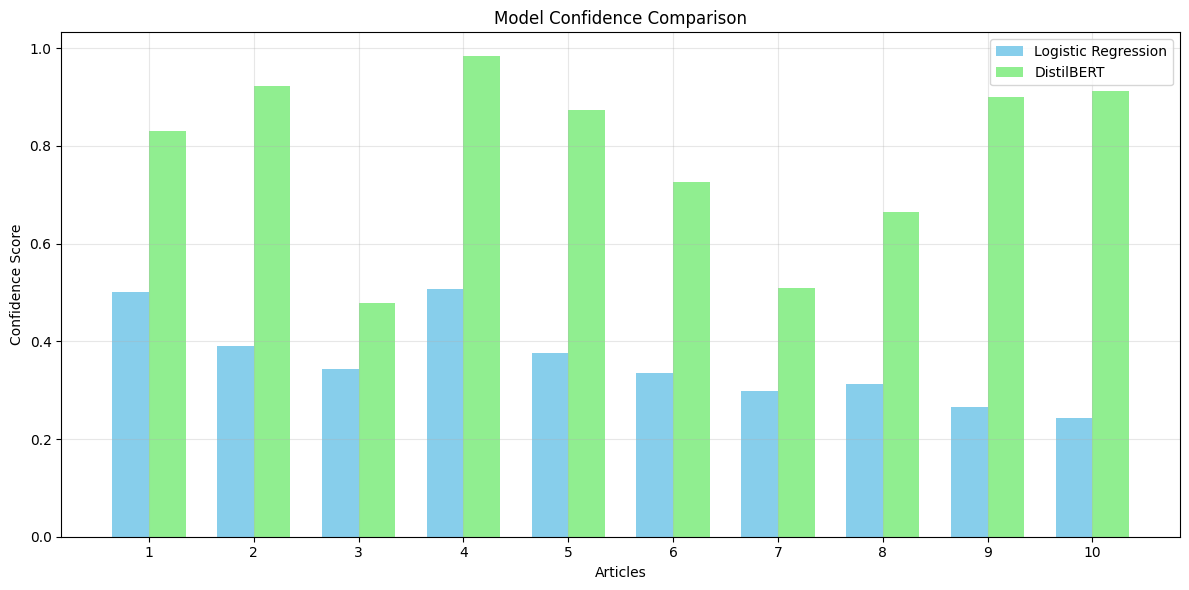

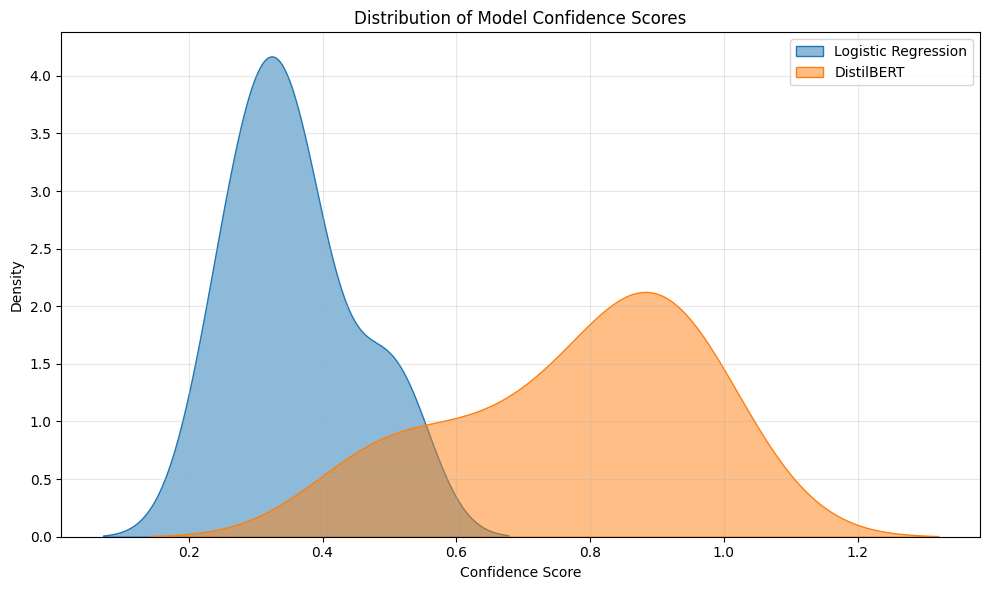

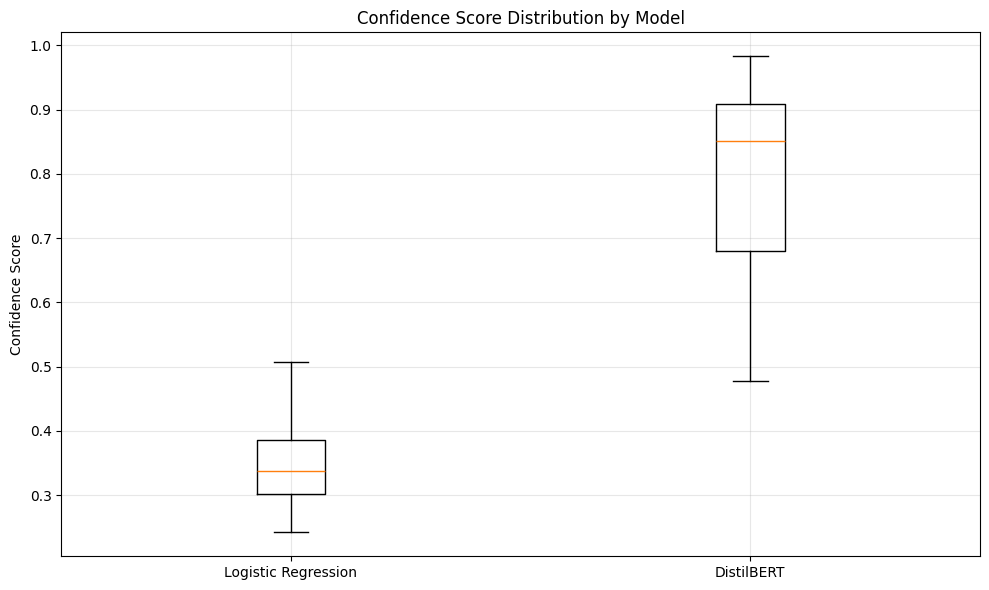

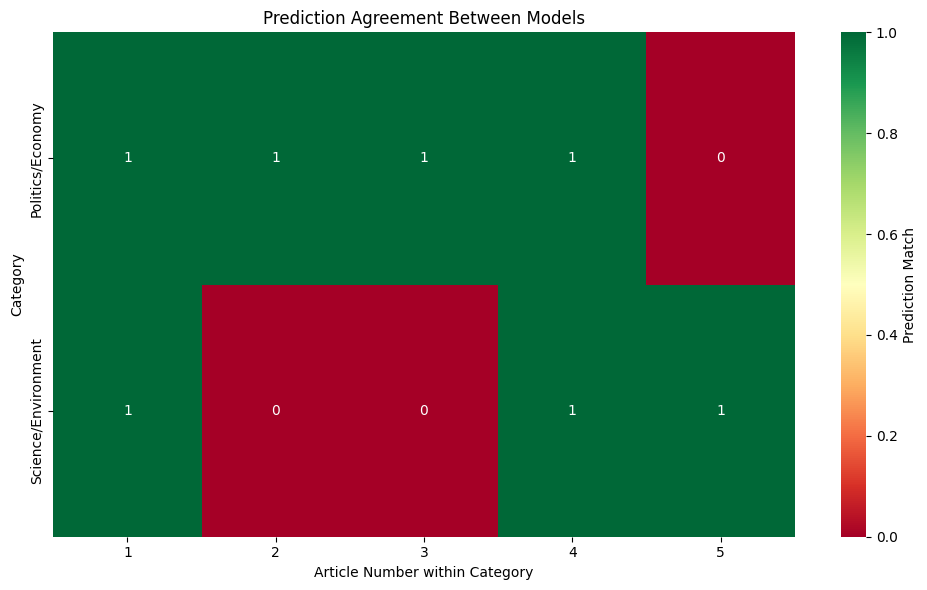

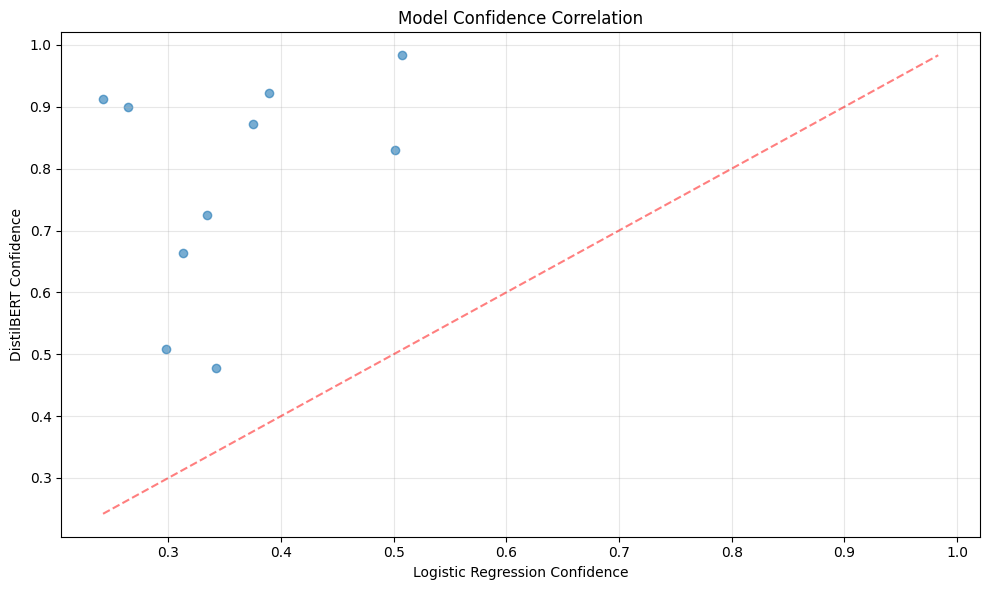


Статистический анализ:

Logistic Regression:
Средняя достоверность: 0.3568
Медианная достоверность: 0.3384
Стандартное отклонение: 0.0853
Мин. достоверность: 0.2421
Макс. достоверность: 0.5075

DistilBERT:
Средняя достоверность: 0.7798
Медианная достоверность: 0.8515
Стандартное отклонение: 0.1690
Мин. достоверность: 0.4783
Макс. достоверность: 0.9833

Процент согласия между моделями: 70.00%


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# ... (предыдущий код остается без изменений) ...

# После получения результатов инференса добавляем визуализацию:

def plot_results(results):
    """
    Создает набор визуализаций для анализа результатов классификации
    """
    
    # 1. Сравнение уверенности моделей (confidence scores)
    plt.figure(figsize=(12, 6))
    
    # Подготовка данных для графика
    categories = [r['category'] for r in results]
    logreg_conf = [r['logreg_confidence'] for r in results]
    distilbert_conf = [r['distilbert_confidence'] for r in results]
    
    x = np.arange(len(results))
    width = 0.35
    
    plt.bar(x - width/2, logreg_conf, width, label='Logistic Regression', color='skyblue')
    plt.bar(x + width/2, distilbert_conf, width, label='DistilBERT', color='lightgreen')
    
    plt.xlabel('Articles')
    plt.ylabel('Confidence Score')
    plt.title('Model Confidence Comparison')
    plt.legend()
    plt.xticks(x, range(1, len(results) + 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('confidence_comparison.png')
    plt.show()

    # 2. Распределение уверенности моделей (density plot)
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=logreg_conf, label='Logistic Regression', fill=True, alpha=0.5)
    sns.kdeplot(data=distilbert_conf, label='DistilBERT', fill=True, alpha=0.5)
    plt.xlabel('Confidence Score')
    plt.ylabel('Density')
    plt.title('Distribution of Model Confidence Scores')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('confidence_distribution.png')
    plt.show()

    # 3. Box plot сравнения уверенности по категориям
    plt.figure(figsize=(10, 6))
    data_to_plot = {
        'Logistic Regression': [conf for cat, conf in zip(categories, logreg_conf)],
        'DistilBERT': [conf for cat, conf in zip(categories, distilbert_conf)]
    }
    
    plt.boxplot(data_to_plot.values(), labels=data_to_plot.keys())
    plt.ylabel('Confidence Score')
    plt.title('Confidence Score Distribution by Model')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('confidence_boxplot.png')
    plt.show()

    # 4. Тепловая карта правильности предсказаний
    plt.figure(figsize=(10, 6))
    prediction_match = [1 if r['logreg_pred'] == r['distilbert_pred'] else 0 for r in results]
    match_matrix = np.array(prediction_match).reshape(len(results)//5, 5)
    
    sns.heatmap(match_matrix, 
                cmap='RdYlGn',
                annot=True,
                fmt='.0f',
                cbar_kws={'label': 'Prediction Match'},
                xticklabels=range(1, 6),
                yticklabels=list(set(categories)))
    plt.title('Prediction Agreement Between Models')
    plt.xlabel('Article Number within Category')
    plt.ylabel('Category')
    plt.tight_layout()
    plt.savefig('prediction_agreement.png')
    plt.show()

    # 5. Scatter plot сравнения уверенности моделей
    plt.figure(figsize=(10, 6))
    plt.scatter(logreg_conf, distilbert_conf, alpha=0.6)
    plt.xlabel('Logistic Regression Confidence')
    plt.ylabel('DistilBERT Confidence')
    plt.title('Model Confidence Correlation')
    
    # Добавляем линию y=x для сравнения
    max_conf = max(max(logreg_conf), max(distilbert_conf))
    min_conf = min(min(logreg_conf), min(distilbert_conf))
    plt.plot([min_conf, max_conf], [min_conf, max_conf], 'r--', alpha=0.5)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('confidence_correlation.png')
    plt.show()

# Добавляем статистический анализ
def print_statistical_analysis(results):
    """
    Выводит статистический анализ результатов
    """
    logreg_conf = [r['logreg_confidence'] for r in results]
    distilbert_conf = [r['distilbert_confidence'] for r in results]
    
    print("\nСтатистический анализ:")
    print("="*50)
    
    print("\nLogistic Regression:")
    print(f"Средняя достоверность: {np.mean(logreg_conf):.4f}")
    print(f"Медианная достоверность: {np.median(logreg_conf):.4f}")
    print(f"Стандартное отклонение: {np.std(logreg_conf):.4f}")
    print(f"Мин. достоверность: {np.min(logreg_conf):.4f}")
    print(f"Макс. достоверность: {np.max(logreg_conf):.4f}")
    
    print("\nDistilBERT:")
    print(f"Средняя достоверность: {np.mean(distilbert_conf):.4f}")
    print(f"Медианная достоверность: {np.median(distilbert_conf):.4f}")
    print(f"Стандартное отклонение: {np.std(distilbert_conf):.4f}")
    print(f"Мин. достоверность: {np.min(distilbert_conf):.4f}")
    print(f"Макс. достоверность: {np.max(distilbert_conf):.4f}")
    
    # Процент согласия между моделями
    agreement = sum(1 for r in results if r['logreg_pred'] == r['distilbert_pred'])
    agreement_rate = agreement / len(results)
    print(f"\nПроцент согласия между моделями: {agreement_rate*100:.2f}%")

# После выполнения инференса добавляем:
plot_results(results)
print_statistical_analysis(results)

## Выводы: 
1. Процент согласия между моделями в  70.00% означает, что в 70% случаев модели предсказывают один и тот же класс. Оставшиеся 30% случаев — это расхождения в предсказаниях, где DistilBERT, вероятно, демонстрирует более высокую точность благодаря своей способности учитывать контекст.
   
2. Logistic Regression: 
- Низкая достоверность в предсказаниях.
- Ограниченная способность учитывать контекст и семантику текста.
- Подходит для простых задач, но не для сложных текстовых данных.
3. DistilBERT:
- Высокая достоверность  в предсказаниях.
- Лучше учитывает контекст и семантику текста.
- Более надежная и точная модель для классификации текстов.